# Notebook pour la simulation circulaire du ressaut hydraulique

Noé DANIEL & Richard PATEAU

In [91]:
import numpy as np
import matplotlib.pyplot as plt

Paramètres physiques et de la simulation (vérification faite au préalable sur le respect de la CFL)

In [92]:
g = 9.81
r_min = 0.01
r_max = 0.3
Nr    = 200
dr    = (r_max - r_min)/Nr
r     = np.linspace(r_min + 0.5*dr, r_max - 0.5*dr, Nr)

# État initial
h_init = 0.01 * np.ones(Nr)
h_init[0] = 0.02   # un peu plus d'eau près du centre
u_init = np.zeros(Nr)
u_init[0] = 1.0

# BC gauche : Dirichlet (h_in, h_in*u_in) = U_left
U_left = np.array([h_init[0], h_init[0]*u_init[0]])


Limiteurs

In [93]:
# Hauteur minimale
h_threshold = 1e-5

dt      = 3e-4
t_max   = 5.0
epsilon = 1e-9  

Fonctions physiques pour equation de Saint-Venant

In [94]:
def compute_flux(U):
    """
    F(U) = (h*u, h*u^2 + 0.5*g*h^2)
    U : shape=(2, Nx)
    """
    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]
    F = np.zeros_like(U)
    F[0,:] = h*u
    F[1,:] = h*u**2 + 0.5*g*h**2
    return F

def source_term(U):
    """
    Terme source axisymétrique:
     S[0,:] = - (h*u)/r
     S[1,:] = - (h*u^2 + 0.5*g*h^2)/r
    """
    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]
    S = np.zeros_like(U)
    S[0,:] = - (h*u)/r
    S[1,:] = - (h*u**2 + 0.5*g*h**2)/r
    return S

### Génération des schémas de construction des flux numériques

Flux de Rusanov

In [95]:
def flux_rusanov(U_L, U_R):
    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    hL, huL = U_L
    hR, huR = U_R
    uL = huL/(hL+1e-10)
    uR = huR/(hR+1e-10)
    cL = np.sqrt(g*hL)
    cR = np.sqrt(g*hR)
    smax = max(abs(uL)+cL, abs(uR)+cR)
    return 0.5*(F_L + F_R) - 0.5*smax*(U_R - U_L)

Flux de Roe

In [96]:
def flux_roe(U_L, U_R):

    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    
    hL, huL = U_L
    hR, huR = U_R
    
    if (hL<1e-14 and hR<1e-14):
        # pas d'eau, flux nul
        return 0.5*(F_L + F_R)  # ou 0.0

    uL = huL/(hL+1e-14)
    uR = huR/(hR+1e-14)
    
    # On fait la moyenne de Roe
    sqrt_hL = np.sqrt(hL+1e-14)     #On evite les 0
    sqrt_hR = np.sqrt(hR+1e-14)
    h_tilde = sqrt_hL*sqrt_hR 
    u_tilde = (sqrt_hL*uL + sqrt_hR*uR)/(sqrt_hL + sqrt_hR + 1e-14)
    c_tilde = np.sqrt(g*h_tilde)
    
    # On calcule les valeurs propres
    lam1 = u_tilde - c_tilde
    lam2 = u_tilde + c_tilde
    
    # On construit R (2x2) (Matrice de passage)
    R = np.array([[1.,              1.            ],
                  [u_tilde-c_tilde, u_tilde+c_tilde]])
    
    # Calcul de l'inverse $R^{-1}$
    inv_2c = 1./(2.*c_tilde+1e-14)
    Rinv = np.array([[ inv_2c*( u_tilde + c_tilde ),    -inv_2c ],
                     [ -inv_2c*(u_tilde - c_tilde ),     inv_2c ]])
    
    # difference dU pour projection
    dU = np.array([ hR - hL,  huR - huL ])
    alpha = Rinv.dot(dU)
    
    # Diago
    Lambda = np.array([ [abs(lam1), 0.        ],
                        [0.,         abs(lam2)] ])
    
    # Flux de roe recalculé
    flux_diff = R.dot( Lambda.dot( alpha ) )
    
    flux = 0.5*(F_L + F_R) - 0.5*flux_diff
    return flux

Flux HLL

In [97]:
def flux_hll(U_L, U_R):

    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]

    hL, huL = U_L
    hR, huR = U_R

    uL = 0.0
    if hL > 1e-14:
        uL = huL / hL
    uR = 0.0
    if hR > 1e-14:
        uR = huR / hR

    cL = np.sqrt(g * hL)
    cR = np.sqrt(g * hR)

    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)

    if SL >= 0:
        # Tout flux = F_L
        return F_L
    elif SR <= 0:
        # Tout flux = F_R
        return F_R
    else:
        # Cas intermédiaire : on construit le flux HLL
        return (SR * F_L - SL * F_R + SL * SR * (U_R - U_L)) / (SR - SL)

Flux HLLC

In [98]:
def flux_hllc(U_L, U_R):

    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    
    hL, huL = U_L
    hR, huR = U_R

    uL = huL/(hL+1e-14)
    uR = huR/(hR+1e-14)
    cL = np.sqrt(g*hL)
    cR = np.sqrt(g*hR)
    
    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)
    
    if SL>=0:
        return F_L
    elif SR<=0:
        return F_R
    else:
        # pL = 0.5*g*hL^2, pR = ...
        pL = 0.5*g*hL**2
        pR = 0.5*g*hR**2
        # S_star
        num = (SR - uR)*hR*uR - (SL - uL)*hL*uL + (pL - pR)
        den = hR*(SR - uR) - hL*(SL - uL)
        if abs(den)<1e-14:
            S_star = 0.5*(uL + uR)
        else:
            S_star = num/(den+1e-14)
        
        if (SL - S_star)==0:
            h_star_L = hL
        else:
            h_star_L = hL*(SL - uL)/((SL - S_star)+1e-14)
        if (SR - S_star)==0:
            h_star_R = hR
        else:
            h_star_R = hR*(SR - uR)/((SR - S_star)+1e-14)
        
        QL = np.array([hL, huL])
        QR = np.array([hR, huR])
        Qstar_L = np.array([h_star_L, h_star_L*S_star])
        Qstar_R = np.array([h_star_R, h_star_R*S_star])
        
        Fstar_L = F_L + SL*( Qstar_L - QL )
        Fstar_R = F_R + SR*( Qstar_R - QR )
        
        if S_star>=0:
            return Fstar_L
        else:
            return Fstar_R

MUSCL avec minmod et Rusanov

In [106]:
def minmod(a, b):
    out = np.zeros_like(a)
    mask = (a*b>0)
    out[mask] = np.where(np.abs(a[mask])<np.abs(b[mask]), a[mask], b[mask])
    return out

def muscl_step(U, dt, flux_func):

    Nr = U.shape[1]
    dU = (U[:,1:] - U[:,:-1])
    dU_L = np.zeros_like(dU)
    dU_R = np.zeros_like(dU)
    dU_L[:,1:] = dU[:,:-1]
    dU_R[:,:-1]= dU[:,1:]
    slope = minmod(dU_L, dU_R)
    
    Fnum = np.zeros((2, Nr+1))
    for j in range(1, Nr):
        UL = U[:, j-1]
        UR = U[:, j]
        sL = slope[:, j-1]
        sR = slope[:, j-1]  # On peut affiner
        UL_face = UL + 0.5*sL
        UR_face = UR - 0.5*sR
        Fnum[:, j] = flux_func(UL_face, UR_face)
    
    # BC flux
    Fnum[:, 0]         = flux_func(U_left, U[:,0])
    Fnum[:, Nr]  = flux_func(U[:, Nr-1], U[:, Nr-1])
    
    S_loc = source_term(U)
    U_new = U.copy()
    for j in range(Nr):
        U_new[:, j] = ( U[:, j]
                        - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                        + dt*S_loc[:, j] )
    
    # BC finales
    U_new[:, 0] = U_left
    U_new[:, -1] = U_new[:, -2]
    
    return U_new

Fonctions de passage de $t$ à $t+dt$

In [100]:
def update_rusanov(U, dt):
    # flux par Rusanov + BC
    Nr = U.shape[1]
    Fnum = np.zeros((2, Nr+1))
    for j in range(1, Nr):
        Fnum[:, j] = flux_rusanov(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_rusanov(U_left, U[:, 0])
    Fnum[:, Nr]  = flux_rusanov(U[:, Nr-1], U[:, Nr-1])
    
    S_loc = source_term(U)
    U_new = U.copy()
    for j in range(Nr):
        U_new[:, j] = U[:, j] - dt/dr*(Fnum[:, j+1]-Fnum[:, j]) + dt*S_loc[:, j]
    
    U_new[:, 0] = U_left
    U_new[:, -1] = U_new[:, -2]
    
    # h<0 fix
    for j in range(Nr):
        if U_new[0,j]<h_threshold:
            U_new[0,j] = 0.
            U_new[1,j] = 0.
    return U_new

def update_roe(U, dt):
    Nr = U.shape[1]
    Fnum = np.zeros((2, Nr+1))
    for j in range(1, Nr):
        Fnum[:, j] = flux_roe(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_roe(U_left, U[:, 0])
    Fnum[:, Nr]  = flux_roe(U[:, Nr-1], U[:, Nr-1])
    
    S_loc = source_term(U)
    U_new = U.copy()
    for j in range(Nr):
        U_new[:, j] = U[:, j] - dt/dr*(Fnum[:, j+1]-Fnum[:, j]) + dt*S_loc[:, j]
    
    U_new[:, 0] = U_left
    U_new[:, -1] = U_new[:, -2]
    
    for j in range(Nr):
        if U_new[0,j]<h_threshold:
            U_new[0,j] = 0.
            U_new[1,j] = 0.
    return U_new

def update_hll(U, dt):
    Nr = U.shape[1]
    U_new = U.copy()
    
    Fnum = np.zeros((2, Nr+1))
    for j in range(1, Nr):
        Fnum[:, j] = flux_hll(U[:, j-1], U[:, j])
    
    Fnum[:, 0] = flux_hll(U_left, U[:, 0])
    Fnum[:, Nr] = flux_hll(U[:, Nr-1], U[:, Nr-1])
    
    S_loc = source_term(U)  
    
    #Euler
    for j in range(Nr):
        U_new[:, j] = (U[:, j]
                       - (dt/dr)*(Fnum[:, j+1] - Fnum[:, j])
                       + dt*S_loc[:, j])
    
    U_new[:, 0] = U_left
    U_new[:, -1] = U_new[:, -2]
    
    for j in range(Nr):
        if U_new[0,j]<h_threshold:
            U_new[0,j] = 0.0
            U_new[1,j] = 0.0
    
    return U_new

def update_hllc(U, dt):
    Nr = U.shape[1]
    Fnum = np.zeros((2, Nr+1))
    for j in range(1, Nr):
        Fnum[:, j] = flux_hllc(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_hllc(U_left, U[:, 0])
    Fnum[:, Nr]  = flux_hllc(U[:, Nr-1], U[:, Nr-1])
    
    S_loc = source_term(U)
    U_new = U.copy()
    for j in range(Nr):
        U_new[:, j] = U[:, j] - dt/dr*(Fnum[:, j+1]-Fnum[:, j]) + dt*S_loc[:, j]
    
    U_new[:, 0] = U_left
    U_new[:, -1] = U_new[:, -2]
    
    for j in range(Nr):
        if U_new[0,j]<h_threshold:
            U_new[0,j] = 0.
            U_new[1,j] = 0.
    return U_new

def update_muscl(U, dt):
    # MUSCL avec flux Rusanov
    U_new = muscl_step(U, dt, flux_rusanov)
    Nr = U_new.shape[1]
    for j in range(Nr):
        if U_new[0,j]<h_threshold:
            U_new[0,j] = 0.
            U_new[1,j] = 0.
    return U_new

Détection automatique du pseudo-équilibre

In [101]:
def find_jump_location(U):

    Nr = U.shape[1]
    h  = U[0,:]
    hu = U[1,:]
    Fr = np.zeros_like(h)
    mask = (h>1e-10)
    Fr[mask] = np.abs(hu[mask]/h[mask]) / np.sqrt(g*h[mask])

    for i in range(1, Nr):
        if Fr[i-1]>1.0 and Fr[i]<1.0:
            return i, r[i]
    return None, None

jump_positions = []

### Simulation et visualisation

In [102]:

def run_simulation(dt, t_max, epsilon):
    # On crée 5 copies
    U_rus   = np.zeros((2, Nr))
    U_roe   = np.zeros((2, Nr))
    U_hll   = np.zeros((2, Nr))
    U_hllc  = np.zeros((2, Nr))
    U_muscl = np.zeros((2, Nr))
    for arr in (U_rus, U_roe, U_hll, U_hllc, U_muscl):
        arr[0,:] = h_init
        arr[1,:] = h_init*u_init
    
    time_list = []
    rus_data, roe_data, hll_data, hllc_data, muscl_data = [], [], [], [], []
    diff_list = []
    
    t_cur = 0.0
    finished = False
    while not finished:
        time_list.append(t_cur)
        rus_data.append(U_rus.copy())
        roe_data.append(U_roe.copy())
        hll_data.append(U_hll.copy())
        hllc_data.append(U_hllc.copy())
        muscl_data.append(U_muscl.copy())
        
        # update each
        old_rus   = U_rus.copy()
        old_roe   = U_roe.copy()
        old_hll  = U_hll.copy()
        old_hllc  = U_hllc.copy()
        old_muscl = U_muscl.copy()
        
        U_rus_new   = update_rusanov(U_rus, dt)
        U_roe_new   = update_roe(U_roe, dt)
        U_hll_new   = update_hll(U_hll, dt)
        U_hllc_new  = update_hllc(U_hllc, dt)
        U_muscl_new = update_muscl(U_muscl, dt)
        
        diff_rus   = np.max(np.abs(U_rus_new   - old_rus))
        diff_roe   = np.max(np.abs(U_roe_new   - old_roe))
        diff_hll   = np.max(np.abs(U_hll_new  - old_hll))
        diff_hllc  = np.max(np.abs(U_hllc_new  - old_hllc))
        diff_muscl = np.max(np.abs(U_muscl_new - old_muscl))
        
        # on prend le max => convergence si tout petit
        big_diff = max(diff_rus, diff_roe, diff_hll, diff_hllc, diff_muscl)
        diff_list.append(big_diff)
        
        U_rus[:]   = U_rus_new
        U_roe[:]   = U_roe_new
        U_hll[:]   = U_hll_new
        U_hllc[:]  = U_hllc_new
        U_muscl[:] = U_muscl_new
        
        t_cur += dt
        if big_diff < epsilon:
            print(f"Convergence: diff={big_diff:.2e}, t={t_cur:.4f}")
            finished = True
        if t_cur>=t_max:
            print(f"t={t_cur:.4f} >= t_max => on arrête")
            finished = True

        idx_jump, r_jump = find_jump_location(U_rus)
        jump_positions.append(r_jump if r_jump else None)

        print(r_jump)

        if len(jump_positions) > 1 and jump_positions[-1] is not None and jump_positions[-2] is not None:
            if r_jump < jump_positions[-2]:
                print("Jump a reculé !")
                finished = True
    
    # stocke le dernier
    time_list.append(t_cur)
    rus_data.append(U_rus.copy())
    roe_data.append(U_roe.copy())
    hll_data.append(U_hll.copy())
    hllc_data.append(U_hllc.copy())
    muscl_data.append(U_muscl.copy())
    
    return {
      'time':      np.array(time_list),
      'rus_data':  np.array(rus_data),   # shape=(n_snap,2,Nr)
      'roe_data':  np.array(roe_data),
      'hll_data':  np.array(hll_data),
      'hllc_data': np.array(hllc_data),
      'muscl_data':np.array(muscl_data),
      'diff':      np.array(diff_list),
    }



Execution de la simulation

In [103]:
results = run_simulation(dt, t_max, epsilon)
time_array = results['time']

rus_sol   = results['rus_data'] 
roe_sol   = results['roe_data']
hll_sol   = results['hll_data']
hllc_sol  = results['hllc_data']
muscl_sol = results['muscl_data']

diff_array= results['diff']

# Hauteurs finales
h_fin_rus   = rus_sol[-1][0,:]
h_fin_roe   = roe_sol[-1][0,:]
h_fin_hll   = hll_sol[-1][0,:]
h_fin_hllc  = hllc_sol[-1][0,:]
h_fin_muscl = muscl_sol[-1][0,:]

0.013625
0.013625
0.013625
0.013625
0.013625
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.016525
0.016525
0.016525
0.016525
0.016525
0.016525
0.016525
0.017975
0.017975
0.017975
0.017975
0.017975
0.017975
0.017975
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.02812500

In [104]:
hu_fin_rus   = rus_sol[-1][1,:]
hu_fin_roe   = roe_sol[-1][1,:]
hu_fin_hll   = hll_sol[-1][1,:]
hu_fin_hllc  = hllc_sol[-1][1,:]
hu_fin_muscl = muscl_sol[-1][1,:]

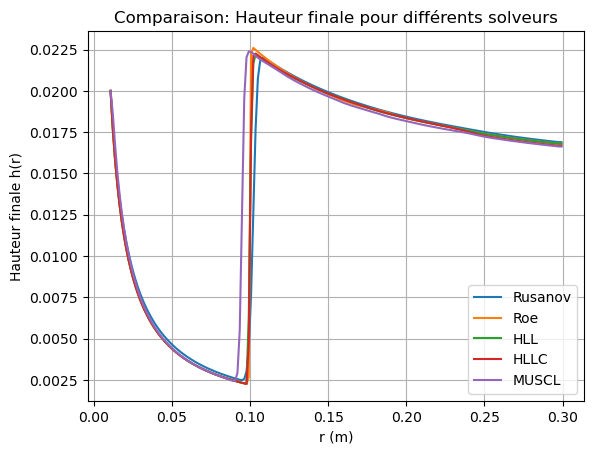

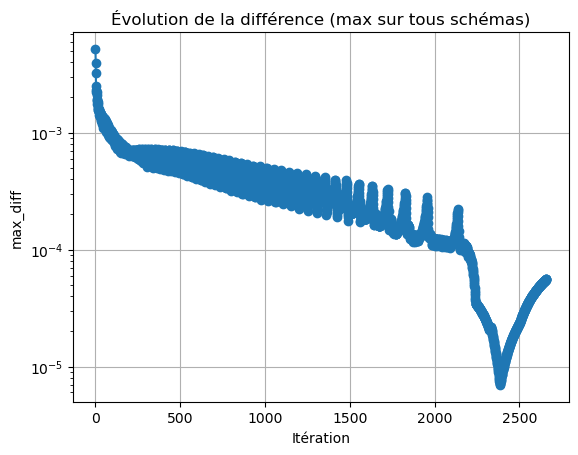

In [80]:
plt.figure()
plt.plot(r, h_fin_rus,   label='Rusanov')
plt.plot(r, h_fin_roe,   label='Roe')
plt.plot(r, h_fin_hll,   label='HLL')
plt.plot(r, h_fin_hllc,  label='HLLC')
plt.plot(r, h_fin_muscl, label='MUSCL')
plt.xlabel('r (m)')
plt.ylabel('Hauteur finale h(r)')
plt.title('Comparaison: Hauteur finale pour différents solveurs')
plt.legend()
plt.grid()


# evolution de la diff
plt.figure()
plt.plot(diff_array, '-o')
plt.yscale('log')
plt.xlabel('Itération')
plt.ylabel('max_diff')
plt.title('Évolution de la différence (max sur tous schémas)')
plt.grid()

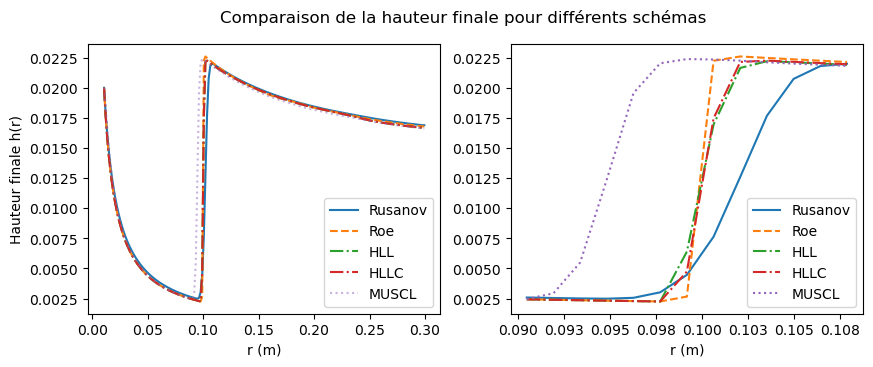

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

axs[0].plot(r, h_fin_rus,   label='Rusanov')
axs[0].plot(r, h_fin_roe,   label='Roe', linestyle='--')
axs[0].plot(r, h_fin_hllc,  label='HLL', linestyle='-.')
axs[0].plot(r, h_fin_hllc,  label='HLLC', linestyle='-.')
axs[0].plot(r, h_fin_muscl, label='MUSCL', linestyle=':', alpha=0.5)
axs[0].set_xlabel('r (m)')
axs[0].set_ylabel('Hauteur finale h(r)')
#axs[0].set_title('Comparaison de la hauteur finale pour différents schémas')
axs[0].legend()


range_1 = int((0.09-0.01)/dr)
range_2 = int((0.11-0.01)/dr)

axs[1].plot(r[range_1: range_2], h_fin_rus[range_1: range_2],   label='Rusanov')
axs[1].plot(r[range_1: range_2], h_fin_roe[range_1: range_2],   label='Roe', linestyle='--')
axs[1].plot(r[range_1: range_2], h_fin_hll[range_1: range_2],  label='HLL', linestyle='-.')
axs[1].plot(r[range_1: range_2], h_fin_hllc[range_1: range_2],  label='HLLC', linestyle='-.')
axs[1].plot(r[range_1: range_2], h_fin_muscl[range_1: range_2], label='MUSCL', linestyle=':')
axs[1].set_xlabel('r (m)')
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.3f}'.format(val)))
axs[1].legend()

fig.suptitle('Comparaison de la hauteur finale pour différents schémas')

fig.savefig("Comparaison_hauteur_finale.svg", bbox_inches='tight')

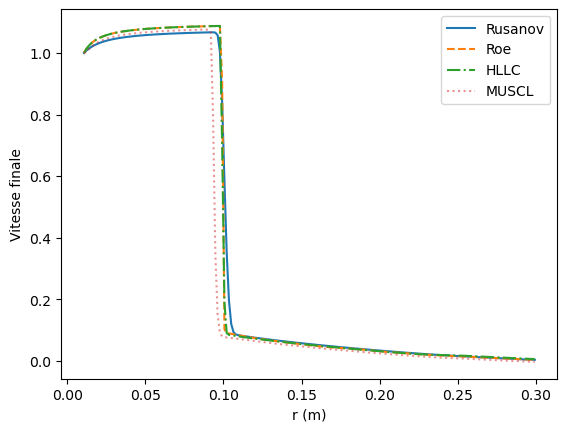

In [53]:
plt.plot(r, hu_fin_rus/h_fin_rus,   label='Rusanov')
plt.plot(r, hu_fin_roe/h_fin_roe,   label='Roe', linestyle='--')
plt.plot(r, hu_fin_hllc/h_fin_hllc,  label='HLLC', linestyle='-.')
plt.plot(r, hu_fin_muscl/h_fin_muscl, label='MUSCL', linestyle=':', alpha=0.5)
plt.xlabel('r (m)')
plt.ylabel('Vitesse finale')

plt.legend()

## Théorie de Froude

In [54]:
hu_fin_roe= roe_sol[-1][1,:]

Fr_Roe = np.zeros_like(h_fin_roe)
mask = (h_fin_roe>1e-10)
Fr_Roe = np.abs(hu_fin_roe[mask]/h_fin_roe[mask]) / np.sqrt(g*h_fin_roe[mask])

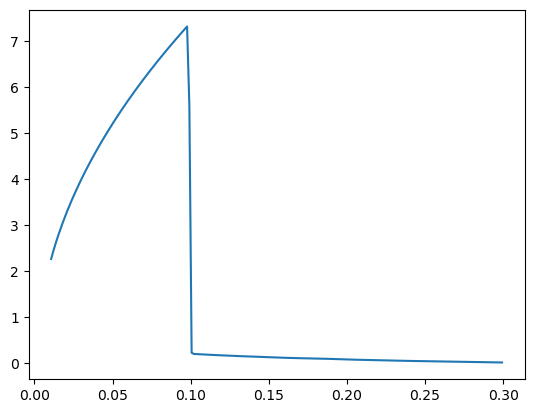

In [55]:
plt.plot(r, Fr_Roe)

In [58]:
i = int((0.095-0.01)/dr)

h_f = h_fin_roe[i]*(np.sqrt(1+8*Fr_Roe[i]**2)-1)/2
print(h_f)

0.022547046577388395


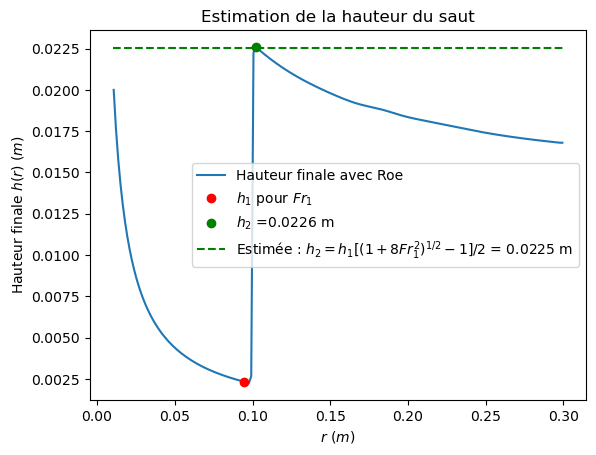

In [89]:
plt.plot(r, h_fin_roe, label='Hauteur finale avec Roe')
plt.plot([r[i]], [h_fin_roe[i]], 'ro', label=r'$h_1$ pour $Fr_1$')
plt.plot([r[np.argmax(h_fin_roe)]], [np.max(h_fin_roe)], 'go', label=r'$h_2$ =' +str(round(np.max(h_fin_roe), 4))+' m')
plt.plot([0.01, 0.3], [h_f, h_f], '--', label=r'Estimée : $h_2 = h_1 [(1+8Fr_1^2)^{1/2} - 1]/2$ = '+str(round(h_f, 4))+' m', color='green')
plt.xlabel(r'$r$ ($m$)')
plt.ylabel(r'Hauteur finale $h(r)$ ($m$)')
plt.legend()

plt.title("Estimation de la hauteur du saut")
plt.savefig("Estimation_hauteur_saut.svg")